# Ontario vs Canada Fire Analysis (1972-2023)

## Overview
Comparative analysis of forest fire patterns between Ontario and Canada from 1972-2023, focusing on fires ≥100 hectares. Uses NBAC dataset to examine total area burned, fire frequency, and size distributions over time.

## Analysis Components
1. **Total Area Burned**: Side-by-side comparison of yearly hectares burned (Ontario vs Canada)
2. **Fire Frequency**: Number of large fires per year comparison
3. **Fire Size Distribution**: LOWESS-smoothed percentile analysis of fire sizes

## Key Questions
- How do Ontario's fire patterns compare to national trends?
- What are the temporal shifts in fire frequency vs. intensity?
- How variable are fire patterns over different time scales?

## Imports and Data Cleaning

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# Load the Excel file - go up one directory level from notebooks/ to access data/
excel_file = "../data/nbac_summarystats_1972_2023_20240530.xlsx"

df = pd.read_excel(excel_file, sheet_name='nbac_1972_2023_20240530')

# drop the first 3 rows and make the 4th row header
df.columns = df.iloc[3]
df = df.drop(index=[0, 1, 2, 3])
df = df.reset_index(drop=True)

# Convert columns to appropriate types
df['YEAR'] = df['YEAR'].astype(int)
df['ADJ_HA'] = df['ADJ_HA'].astype(float)

# make a column for before and after 2006
df['before_after_2006'] = df['YEAR'].apply(lambda x: 'before' if x <= 2006 else 'after')

# exclude all ADJ_HA values that are less than 100
df = df[df['ADJ_HA'] >= 100]

## Ontario vs Canada Fire Comparison

**Total Area Burned**: Ontario burns 100K-700K hectares annually vs Canada's 1-15M hectares (Ontario = ~5-15% of national total)

**Fire Count**: Ontario has 20-150 large fires per year vs Canada's 200-1000 fires (Ontario = ~10-20% of national count)

**Key Insight**: Ontario sometimes has disproportionately large fires relative to its fire count, suggesting regional variations in fire intensity patterns.

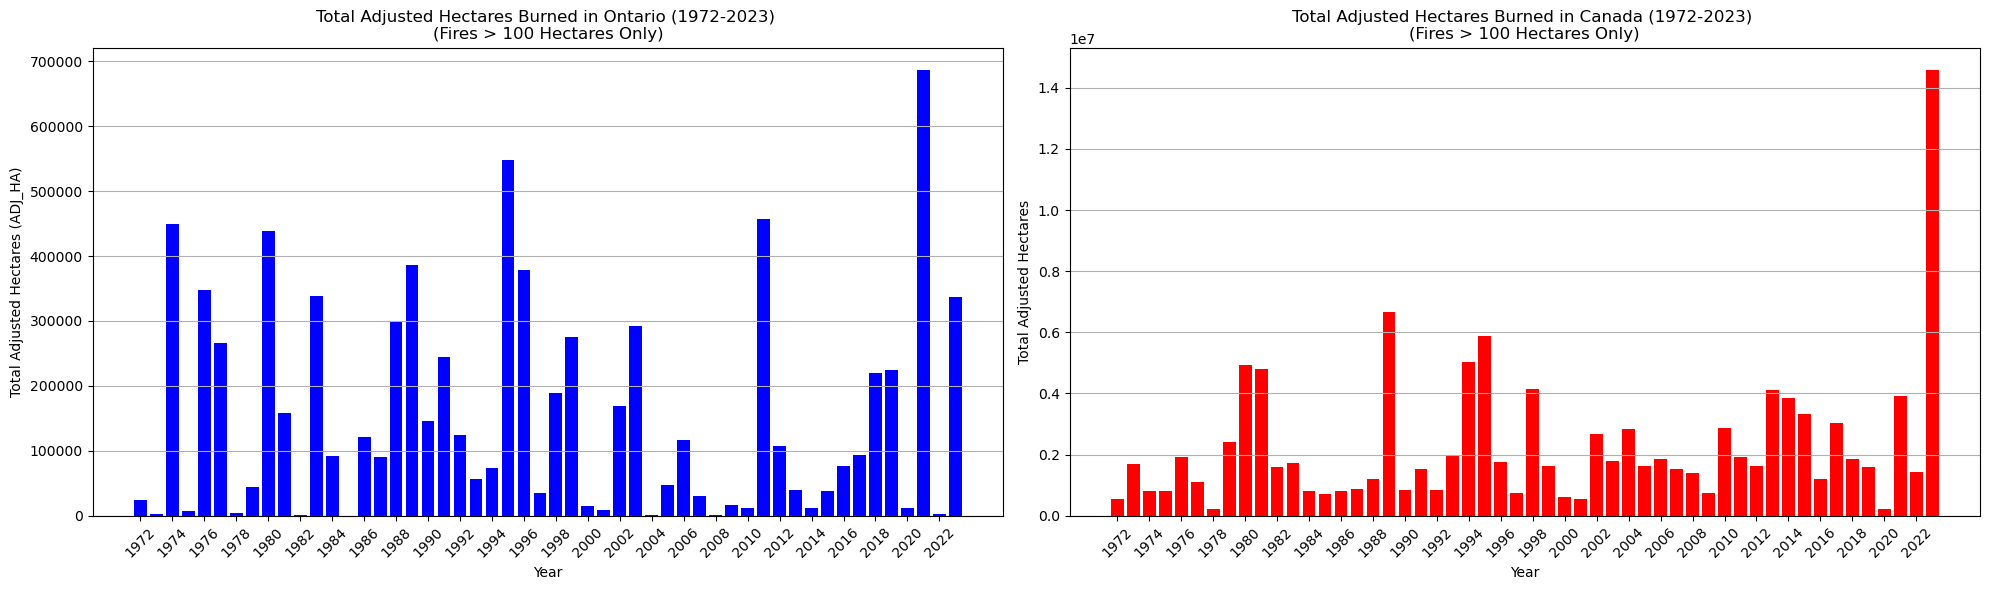

In [4]:
# select only rows with ADMIN_AREA == ON
df_on = df[df['ADMIN_AREA'] == 'ON'].copy()

# sum up the ADJ_HA values for each year
df_on_yearly = df_on.groupby('YEAR')['ADJ_HA'].sum().reset_index()

# sum up the data for each year in total 
df_total_yearly = df.groupby('YEAR')['ADJ_HA'].sum().reset_index()

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Ontario plot (left)
ax1.bar(df_on_yearly['YEAR'], df_on_yearly['ADJ_HA'], color='blue')
ax1.set_title('Total Adjusted Hectares Burned in Ontario (1972-2023) \n(Fires > 100 Hectares Only)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Adjusted Hectares (ADJ_HA)')
ax1.set_xticks(np.arange(1972, 2024, 2))
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y')

# Canada plot (right)
ax2.bar(df_total_yearly['YEAR'], df_total_yearly['ADJ_HA'], color='red')
ax2.set_title('Total Adjusted Hectares Burned in Canada (1972-2023) \n(Fires > 100 Hectares Only)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Total Adjusted Hectares')
ax2.set_xticks(np.arange(1972, 2024, 2))
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y')

plt.tight_layout()
plt.show()

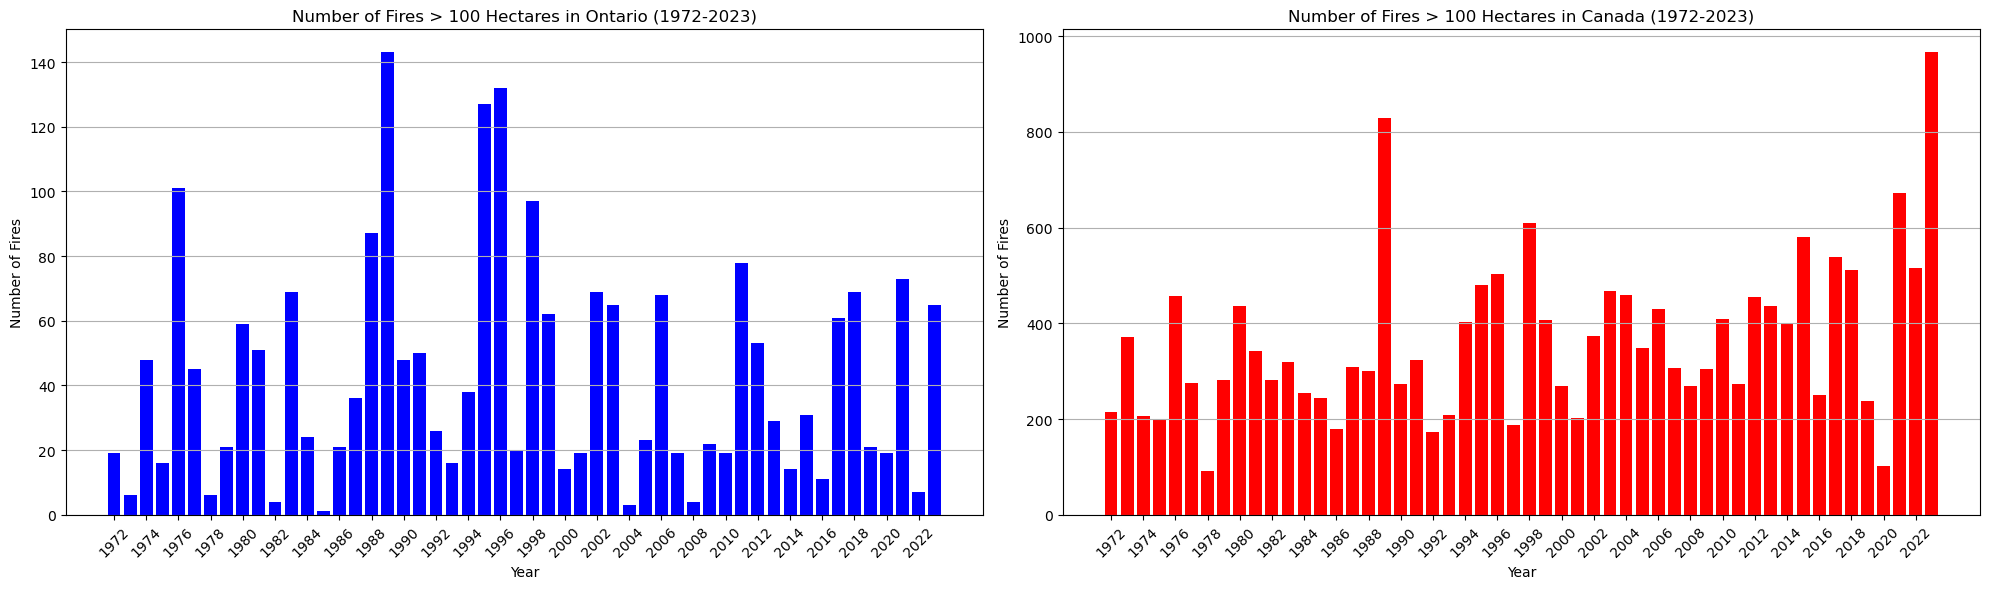

In [5]:
# Number of fires per year (Fires > 100 Hectares Only)
df_fire_count = df.groupby('YEAR').size().reset_index(name='fire_count')
df_fire_count_on = df_on.groupby('YEAR').size().reset_index(name='fire_count')

# Create side-by-side plots for fire counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Ontario fire count plot (left)
ax1.bar(df_fire_count_on['YEAR'], df_fire_count_on['fire_count'], color='blue')
ax1.set_title('Number of Fires > 100 Hectares in Ontario (1972-2023)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Fires')
ax1.set_xticks(np.arange(1972, 2024, 2))
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y')

# Canada fire count plot (right)
ax2.bar(df_fire_count['YEAR'], df_fire_count['fire_count'], color='red')
ax2.set_title('Number of Fires > 100 Hectares in Canada (1972-2023)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Fires')
ax2.set_xticks(np.arange(1972, 2024, 2))
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y')

plt.tight_layout()
plt.show()

## Fire Size Distribution Trends

The LOWESS-smoothed distribution plots reveal important differences between national and regional fire patterns:

**Canada (National Level)**: Fire size distributions have remained relatively steady over the 50-year period, with median fire sizes and variability bands showing modest fluctuations but no dramatic long-term trends.

**Ontario (Regional Level)**: A striking increase in large fire sizes has emerged in recent years. The upper percentiles (95th percentile band) show a sharp upward trend starting around 2010, indicating that while typical fire sizes may remain stable, the largest fires are becoming significantly larger.

**Key Implication**: This divergence suggests Ontario is experiencing more extreme fire events in recent decades, even as national patterns remain relatively stable. This could reflect regional climate changes, forest management practices, or other localized factors affecting fire behavior in Ontario specifically.

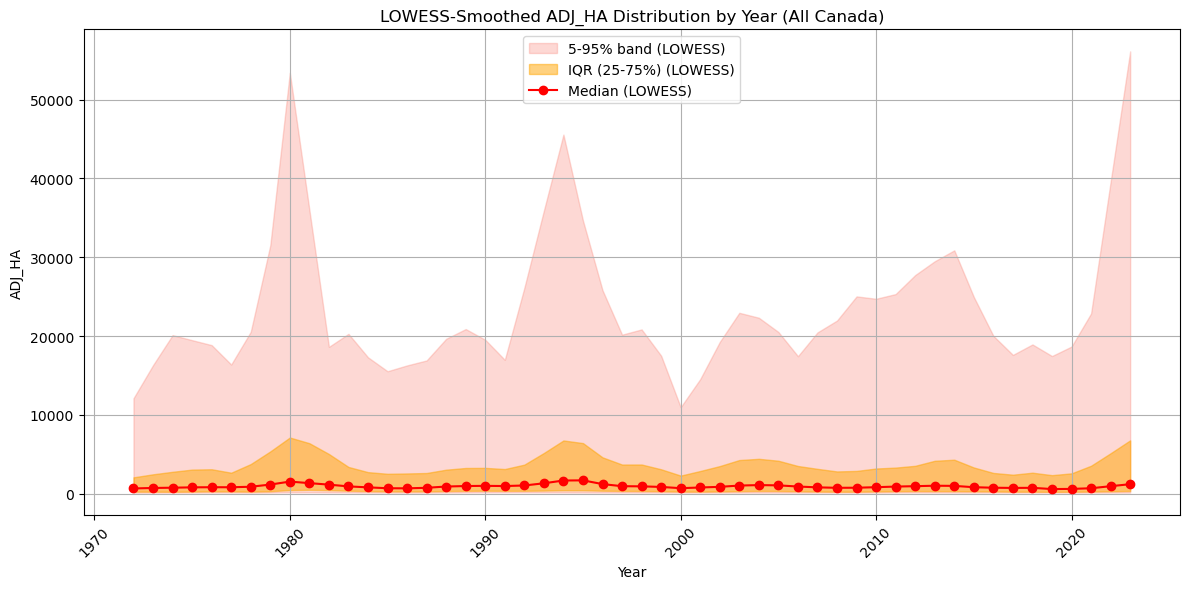

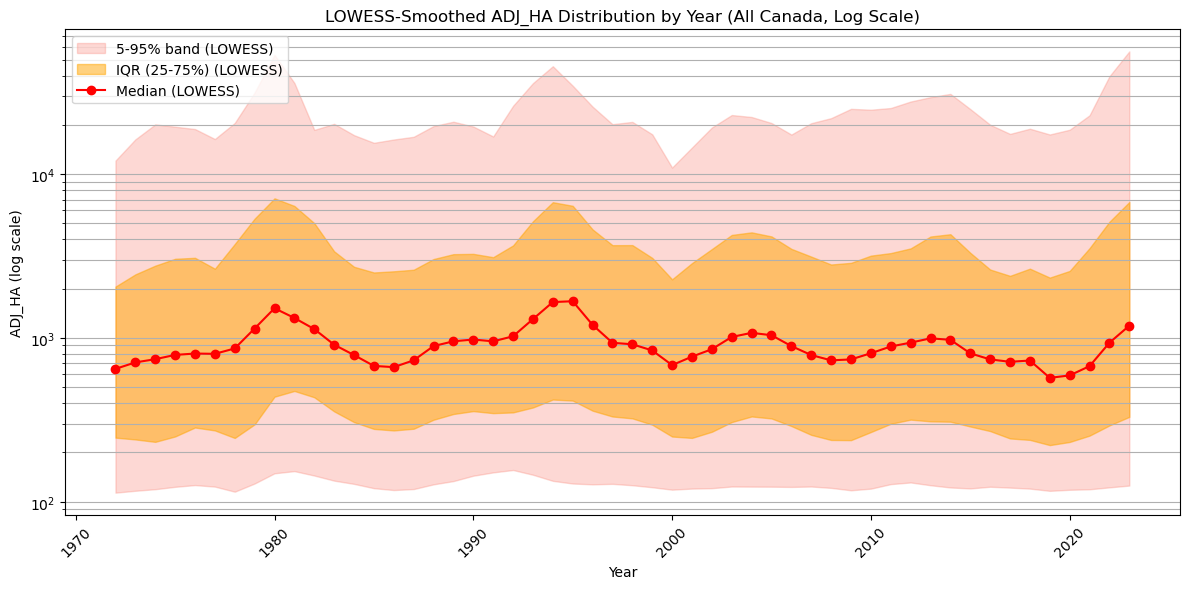

In [ ]:
# Group by year and aggregate statistics for ADJ_HA
stats = df.groupby('YEAR')['ADJ_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

x = stats['YEAR'].values
lowess_smooth = {}
frac = 0.1  # Smoothing parameter

for col in ['median', 'q25', 'q75', 'p5', 'p95']:
    y = stats[col].values
    smoothed = lowess(y, x, frac=frac, return_sorted=False)
    lowess_smooth[col] = smoothed

plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed ADJ_HA Distribution by Year (All Canada)')
plt.xlabel('Year')
plt.ylabel('ADJ_HA')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Log scale version
plt.figure(figsize=(12, 6))
plt.fill_between(x, lowess_smooth['p5'], lowess_smooth['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x, lowess_smooth['q25'], lowess_smooth['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x, lowess_smooth['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed ADJ_HA Distribution by Year (All Canada, Log Scale)')
plt.xlabel('Year')
plt.ylabel('ADJ_HA (log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()
plt.show()

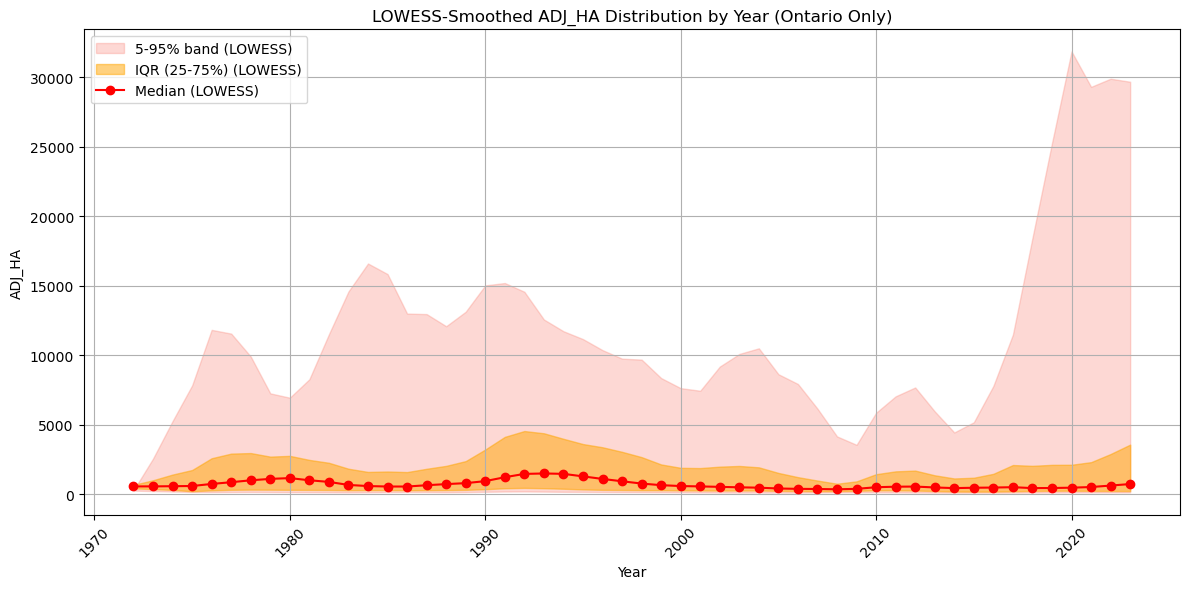

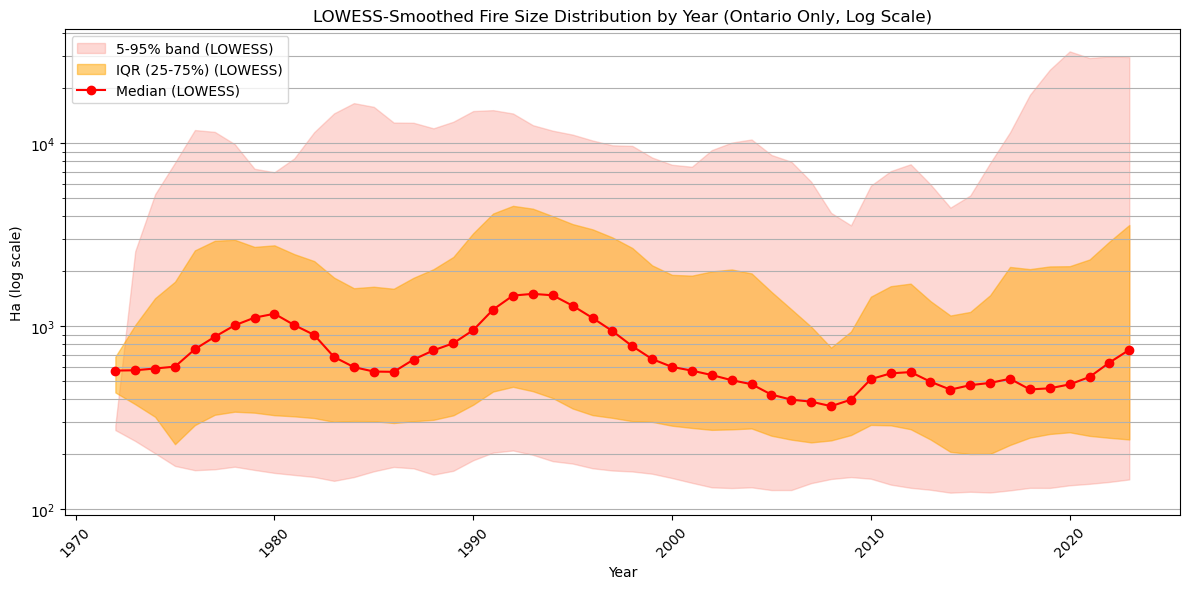

In [ ]:
# Group by year and aggregate statistics for ADJ_HA in Ontario
stats_on = df_on.groupby('YEAR')['ADJ_HA'].agg([
    ('median', 'median'),
    ('q25', lambda x: np.percentile(x, 25)),
    ('q75', lambda x: np.percentile(x, 75)),
    ('p5', lambda x: np.percentile(x, 5)),
    ('p95', lambda x: np.percentile(x, 95))
]).reset_index()

x_on = stats_on['YEAR'].values
lowess_smooth_on = {}
frac = 0.15  # Smoothing parameter

for col in ['median', 'q25', 'q75', 'p5', 'p95']:
    y = stats_on[col].values
    smoothed = lowess(y, x_on, frac=frac, return_sorted=False)
    lowess_smooth_on[col] = smoothed

plt.figure(figsize=(12, 6))
plt.fill_between(x_on, lowess_smooth_on['p5'], lowess_smooth_on['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x_on, lowess_smooth_on['q25'], lowess_smooth_on['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x_on, lowess_smooth_on['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed ADJ_HA Distribution by Year (Ontario Only)')
plt.xlabel('Year')
plt.ylabel('ADJ_HA')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

# Log scale version
plt.figure(figsize=(12, 6))
plt.fill_between(x_on, lowess_smooth_on['p5'], lowess_smooth_on['p95'], color='salmon', alpha=0.3, label='5-95% band (LOWESS)')
plt.fill_between(x_on, lowess_smooth_on['q25'], lowess_smooth_on['q75'], color='orange', alpha=0.5, label='IQR (25-75%) (LOWESS)')
plt.plot(x_on, lowess_smooth_on['median'], color='red', marker='o', label='Median (LOWESS)')
plt.title('LOWESS-Smoothed Fire Size Distribution by Year (Ontario Only, Log Scale)')
plt.xlabel('Year')
plt.ylabel('Ha (log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.legend()
plt.show()